In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
#%% Data Loading and Preprocessing

hts_df = pd.read_csv('hts_example.csv', index_col=None)

# One-hot encode the selected data
encoder = OneHotEncoder(sparse=False)
one_hot_data = encoder.fit_transform(hts_df.values)

# Convert the data to torch tensors
data_tensor = torch.tensor(one_hot_data, dtype=torch.float32)
dataset = TensorDataset(data_tensor)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create DataLoader with batch size 256
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)



Using device: cuda:0


In [3]:
#%% 2. Defining the Normalizing Flow Model

class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask):
        super(RealNVP, self).__init__()
        # Register mask as a buffer to ensure it moves with the model
        self.register_buffer('mask', mask.float())
        self.s = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )
        self.t = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x):
        x_masked = x * self.mask
        s = self.s(x_masked) * (1 - self.mask)
        t = self.t(x_masked) * (1 - self.mask)
        y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det_jacobian = ((1 - self.mask) * s).sum(dim=1)
        return y, log_det_jacobian
    
    def inverse(self, y):
        y_masked = y * self.mask
        s = self.s(y_masked) * (1 - self.mask)
        t = self.t(y_masked) * (1 - self.mask)
        x = y_masked + (1 - self.mask) * (y - t) * torch.exp(-s)
        log_det_jacobian = -((1 - self.mask) * s).sum(dim=1)
        return x, log_det_jacobian

class NormalizingFlowModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_flows, device):
        super(NormalizingFlowModel, self).__init__()
        self.device = device
        self.prior = torch.distributions.MultivariateNormal(
            torch.zeros(input_dim).to(device), torch.eye(input_dim).to(device)
        )
        self.flows = nn.ModuleList()
        # Create alternating binary masks
        mask = (torch.arange(0, input_dim) % 2).to(device).float()
        for _ in range(n_flows):
            self.flows.append(RealNVP(input_dim, hidden_dim, mask))
            mask = 1 - mask  # Alternate mask
    
    def forward(self, x):
        log_det_jacobian = torch.zeros(x.size(0), device=self.device)
        for flow in self.flows:
            x, ldj = flow(x)
            log_det_jacobian += ldj
        return x, log_det_jacobian
    
    def inverse(self, z):
        for flow in reversed(self.flows):
            z, _ = flow.inverse(z)
        return z


In [4]:
#%% 3. Training the Normalizing Flow Model

# Hyperparameters
input_dim = data_tensor.shape[1]
hidden_dim = 256
n_flows = 10  # Adjust as needed
batch_size = 256
num_epochs = 30  # Increase epochs for better results
learning_rate = 5e-5  # Adjust learning rate if needed

# Initialize model and optimizer
model = NormalizingFlowModel(input_dim, hidden_dim, n_flows, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch in data_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        z, log_det_jacobian = model(x)
        log_prob_z = model.prior.log_prob(z)
        loss = - (log_prob_z + log_det_jacobian).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    avg_loss = total_loss / len(data_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/30, Loss: 23.0030
Epoch 2/30, Loss: -3.9714
Epoch 3/30, Loss: -22.4389
Epoch 4/30, Loss: -33.5442
Epoch 5/30, Loss: -40.9540
Epoch 6/30, Loss: -46.2076
Epoch 7/30, Loss: -50.3584
Epoch 8/30, Loss: -53.2485
Epoch 9/30, Loss: -55.9243
Epoch 10/30, Loss: -57.8364
Epoch 11/30, Loss: -59.9861
Epoch 12/30, Loss: -61.5628
Epoch 13/30, Loss: -63.1685
Epoch 14/30, Loss: -65.0154
Epoch 15/30, Loss: -66.1951
Epoch 16/30, Loss: -67.7660
Epoch 17/30, Loss: -68.9915
Epoch 18/30, Loss: -69.6656
Epoch 19/30, Loss: -70.8880
Epoch 20/30, Loss: -71.5311
Epoch 21/30, Loss: -72.4021
Epoch 22/30, Loss: -72.5925
Epoch 23/30, Loss: -74.1842
Epoch 24/30, Loss: -74.5827
Epoch 25/30, Loss: -75.0642
Epoch 26/30, Loss: -75.7618
Epoch 27/30, Loss: -75.3445
Epoch 28/30, Loss: -76.9241
Epoch 29/30, Loss: -77.6842
Epoch 30/30, Loss: -77.9262


In [10]:
torch.save(model.state_dict(), 'models/nf_discrete.pth')

In [5]:
model.eval()
num_samples_gen = 3000  # Adjust the number of samples as needed

with torch.no_grad():
    z = model.prior.sample((num_samples_gen,)).to(device)
    x_gen = model.inverse(z)

x_gen = x_gen.cpu()

In [6]:
#%% 5. Mapping Back to Categorical Data

# Convert generated tensor to numpy array
x_gen_np = x_gen.numpy()

# Get the number of categories per feature
n_categories = [len(cat) for cat in encoder.categories_]
indices = np.cumsum([0] + n_categories)

# Map back to categories
generated_data = []
for sample in x_gen_np:
    sample_categories = []
    for i in range(len(n_categories)):
        start_idx = indices[i]
        end_idx = indices[i + 1]
        logits = sample[start_idx:end_idx]
        # Apply the log-sum-exp trick for numerical stability
        logits = logits - np.max(logits)  # Subtract max logits to prevent overflow
        probs = np.exp(logits) / np.exp(logits).sum()
        # Get the category with the highest probability
        category_idx = np.argmax(probs)
        category_value = encoder.categories_[i][category_idx]
        sample_categories.append(category_value)
    generated_data.append(sample_categories)

# Convert generated data to a DataFrame
generated_data = np.array(generated_data)
generated_df = pd.DataFrame(generated_data, columns=['start_type', 'act_num', 'mode_num', 'end_type'])


Generated data sample:
   start_type  act_num  mode_num  end_type
0         0.0      1.0       4.0       2.0
1         2.0      5.0       2.0       3.0
2         0.0      1.0       4.0       1.0
3         0.0      0.0       1.0       0.0
4         0.0      5.0       2.0       4.0


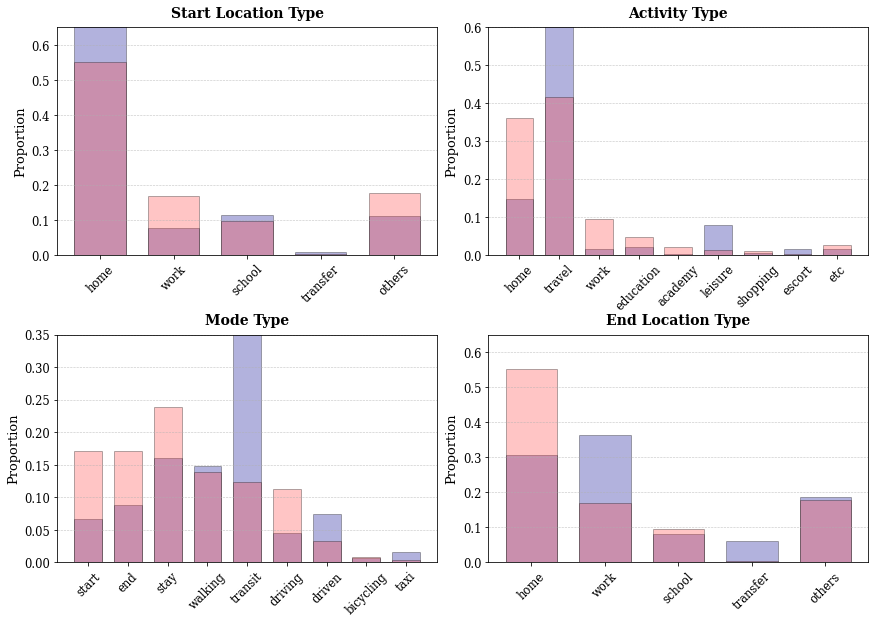

In [9]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(h_pad=6, w_pad=2)

ticks_list = [5, 9, 9, 5]
attribute_list = ['start_type', 'act_num', 'mode_num', 'end_type']
title_list = ['Start Location Type', 'Activity Type', 'Mode Type', 'End Location Type']
location_list = ['home', 'work', 'school', 'transfer', 'others']
act_list = ['home', 'travel', 'work', 'education', 'academy', 'leisure', 'shopping', 'escort', 'etc']
mode_list = ['start', 'end', 'stay', 'walking', 'transit', 'driving', 'driven', 'bicycling', 'taxi']
axis_list = [location_list, act_list, mode_list, location_list]
ylim_list = [0.65, 0.6, 0.35, 0.65]

start = 0

for K, name, title, axis, ylim, ax in zip(ticks_list, attribute_list, title_list, axis_list, ylim_list, axs.flatten()):

    unique, counts = np.unique(generated_data[:, start], return_counts=True)
    ax.set_ylim([0, ylim])
    ax.bar(unique, counts/counts.sum(), color='#00008F', edgecolor='black', width=0.7, alpha=0.3)
    
    unique, counts = np.unique(hts_df[name].values, return_counts=True)
    ax.set_ylim([0, ylim])
    ax.bar(unique, counts/counts.sum(), color='#FF4040', edgecolor='black', width=0.7, alpha=0.3)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_xticks(np.arange(K))
    ax.tick_params(axis='both', which='major', labelsize=11.5)
    ax.set_xticklabels(axis, rotation=45)
    ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)
    ax.set_ylabel('Proportion', fontsize=13)
    end = start + 1
    start = end

plt.savefig(f'nf_discrete.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()